<H2>課題2: 予測モデルの作成</H2>
<p>本課題では課題1と同じデータを用いてデータ分析の流れを確認します。</p>
<p>2章で学んだ内容を踏まえ、各セルに入っているコメントを実行するコードを記入してください。</p>

<H2>1. 必要なモジュールを読み込む</H2>

In [26]:
% matplotlib inline

from __future__ import print_function

import copy

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

matplotlib.style.use('ggplot')

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

<H2>2. データの読み込み</H2>
<p> pandasにはread_csvという関数が用意されており、それを用いれば簡単にCSVファイルを読み込むことができます</p>
<p>データはdatasetフォルダ直下にある"kaggle_housing_price.csv"を使用します。</p>

In [27]:
# データ読み込み
dataset = pd.read_csv('kaggle_housing_price.csv')

In [28]:
# データを最初の5行だけ表示
dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<h2>3. データの前処理</h2>

In [29]:
# 今回の解析では下記の列を使用することとします
target_col = 'SalePrice'
feature_cols = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
               'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'GarageCars']

In [30]:
# target_colとfeature_colsをarrayにして、それぞれをY、Xとする
y = np.array(dataset[target_col])
X = np.array(dataset[feature_cols])

In [31]:
# DataをTrain　: Test = 7　:　3に分ける
X_train,X_test,y_train,y_test = \
train_test_split(X,y,test_size=0.3,random_state=1234)

In [32]:
X_train1,X_train2,y_train1,y_train2= \
train_test_split(X_train,y_train,test_size=0.3,random_state=1234)

<H2>4. アルゴリズムの選択 </H2>
<p>回帰分析、決定木、ランダムフォレストを比較します</p>

In [33]:
# 回帰分析を実施しMSEを算出
lm = LinearRegression()
lm.fit(X_train1,y_train1)
y_pred2 = lm.predict(X_train2)
lm_mse = mean_squared_error(y_train2,y_pred2)
print('LinerRegression MSE: ',lm_mse)

LinerRegression MSE:  1569804095.5013518


In [34]:
#決定木を実行し、MSEを算出
dt = DecisionTreeRegressor()
dt.fit(X_train1,y_train1)
y_pred2 = dt.predict(X_train2)
dt_mse = mean_squared_error(y_train2,y_pred2)
print('DT MSE: ',dt_mse)

DT MSE:  1782071316.009772


In [35]:
# ランダムフォレストを実行し、MSEを算出
rf = RandomForestRegressor(random_state=1234)
rf.fit(X_train1,y_train1)
y_pred2 = rf.predict(X_train2)
rf_mse = mean_squared_error(y_train2,y_pred2)
print('RandomForest MSE: ',rf_mse)

RandomForest MSE:  975084587.469381


<H2>5. 変数の選択</H2>

In [36]:
# 変数増加法を実行する関数
def get_gfs_feature_indices(X, y, features, clf):
    X_train_, X_test_, y_train_, y_test_ = \
        train_test_split(X, y, test_size=0.3, random_state=1234)
    feature_indices = {feature: idx for idx, feature in enumerate(features)}
    features = set(features)
    last_mse = np.inf
    chosen_features = set()
    while len(chosen_features) < len(features):
        mse_features = []
        for feature in (features - chosen_features):
            candidates = chosen_features.union(set([feature]))
            indices = [feature_indices[feature] for feature in candidates]
            clf.fit(X_train_[:, indices], y_train_)
            y_pred = clf.predict(X_test_[:, indices])
            mse = mean_squared_error(y_test_, y_pred)
            mse_features += [(mse, feature)]
        mse, feature = min(mse_features)
        if mse >= last_mse:
            break
        last_mse = mse
        print('Newly Added Feature: {},\tMSE Score: {}'.format(feature, mse))
        chosen_features.add(feature)
    return [feature_indices[feature] for feature in chosen_features]

In [37]:
# 上記関数を使用して変数増加法を実行し、MSEを算出
selected_feature_index = \
get_gfs_feature_indices(X=X_train,y=y_train,features=feature_cols,clf=RandomForestRegressor(random_state=1234))

Newly Added Feature: OverallQual,	MSE Score: 2296281254.2751584
Newly Added Feature: GrLivArea,	MSE Score: 1674014637.3431904
Newly Added Feature: 2ndFlrSF,	MSE Score: 1259953539.285693
Newly Added Feature: BsmtFinSF1,	MSE Score: 1033614273.5622487
Newly Added Feature: OverallCond,	MSE Score: 944756038.1570767


<H2>6. ハイパーパラメータのチューニング</H2>

In [40]:
# 木の数：[10, 50, 100], 木の深さ:[5, 10, 50]でパラメータをチューニング
rf = RandomForestRegressor(random_state=1234)
params = {'n_estimators':[10,50,100],'max_depth':[5,10,50]}
gscv = GridSearchCV(rf,param_grid=params,verbose=1,
                    cv=3,scoring='neg_mean_squared_error')
gscv.fit(X_train1[:,selected_feature_index],y_train1)
gscv.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    2.9s finished


{'max_depth': 50, 'n_estimators': 50}

In [43]:
# チューニング後のランダムフォレストで再びMSEを算出し、精度を確認
rf = RandomForestRegressor(n_estimators=50,max_depth=50,random_state=1234)
rf.fit(X_train1[:,selected_feature_index],y_train1)
y_pred2 = rf.predict(X_train2[:,selected_feature_index])
rf_mse = mean_squared_error(y_train2,y_pred2)
print('RandomForest MSE: ',rf_mse)

RandomForest MSE:  938310697.7966133


<H2>7. モデルの評価</H2>

In [45]:
# Test dataを用いてMSEを算出し、予測精度を確認
rf = RandomForestRegressor(n_estimators=50,max_depth=50,random_state=1234)
rf.fit(X_train[:,selected_feature_index],y_train)
y_pred_on_test = rf.predict(X_test[:,selected_feature_index])
rf_mse = mean_squared_error(y_test,y_pred_on_test)
print('RandomForest MSE: ',rf_mse)

RandomForest MSE:  912551271.0793947


<H2>8. エラー分析</H2>

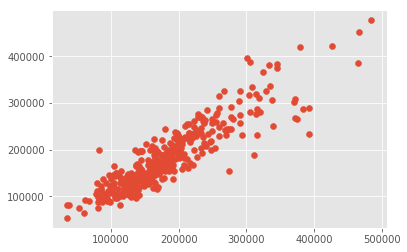

In [46]:
# 横軸：実際の成約価格、縦軸：予測した成約価格で散布図を作成し予測の誤差を確認
plt.scatter(y_test,y_pred_on_test)

Mean:  -0.03325087085722878
Std:  0.19784242854907888


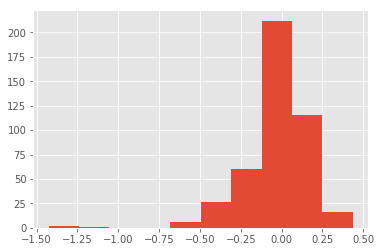

In [47]:
# 実際の成約価格と予測価格の誤差率をヒストグラムで表示
error_rate = (y_test - y_pred_on_test)/y_test
plt.hist(error_rate)
print('Mean: ',np.mean(error_rate))
print('Std: ',np.std(error_rate))